# Introduction

Experimentation on the [Dataset for ADL Recognition with a Wrist-worn Accelerometer](https://archive.ics.uci.edu/ml/datasets/Dataset+for+ADL+Recognition+with+Wrist-worn+Accelerometer).

In [1]:
import os, sys, shutil, glob, requests, zipfile
import numpy as np, sequentia as seq, matplotlib.pyplot as plt
import sequentia.classifiers, sequentia.preprocessing
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

# Silence TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Import utility functions and classes
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import *
from lstm import LSTMClassifier

# ggplot style
plt.style.use('ggplot')

# Set seed for reproducible randomness
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed)

In [2]:
clfs, results = {}, {'hmm': {}, 'knn': {}, 'lstm': {}}

## Downloading and deserializing the data

In [3]:
# A map of the gesture directories to their class names
directory_map = {
    'Brush_teeth': 'brush_teeth',
    'Climb_stairs*': 'climb_stairs',
    'Comb_hair': 'comb_hair',
    'Descend_stairs': 'descend_stairs',
    'Drink_glass*': 'drink_glass',
    'Eat_meat': 'eat_meat',
    'Eat_soup': 'eat_soup',
    'Getup_bed*': 'getup_bed',
    'Liedown_bed': 'liedown_bed',
    'Pour_water*': 'pour_water',
    'Sitdown_chair*': 'sitdown_chair',
    'Standup_chair*': 'standup_chair',
    'Use_telephone': 'use_telephone',
    'Walk*': 'walk'
}

classes = list(directory_map.values())

In [4]:
def file_to_numpy(file):
    """Convert acceleration parameter .txt file to np.ndarray"""
    with open(file) as f:
        X = []
        for line in f:
            Ax, Ay, Az = line.strip('\n').split()
            X.append([float(Ax), float(Ay), float(Az)])
    return np.array(X)

In [5]:
X, y = [], []
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00283/ADL_Dataset.zip'

try:
    path, zip_path = 'HMP_Dataset', 'ADL_Dataset.zip'
    print('Downloading dataset from {} ...'.format(url))
    response = requests.get(url)
    with open(zip_path, 'wb') as f:
        print('Writing {} ...'.format(zip_path))
        f.write(response.content)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        print('Extracting {} ...'.format(zip_path))
        zip_ref.extractall()
except:
    raise
else:
    print('Reading data into Numpy arrays ...')
    for pattern, label in directory_map.items():
        for folder in glob.glob(os.path.join(path, pattern)):
            for txt in glob.glob(os.path.join(folder, '*.txt')):
                X.append(file_to_numpy(txt))
                y.append(label)
    print('Done!')
finally:
    os.remove(zip_path)
    shutil.rmtree(path)

Writing ADL_Dataset.zip ...
Extracting ADL_Dataset.zip ...
Reading data into Numpy arrays ...
Done!


## Removing infrequent classes

The `eat_meat` and `eat_soup` classes are too infrequent for the dataset to be stratified into an equal training, validation and test set split, so we remove them.

In [6]:
# Remove instances of the infrequent classes from the dataset
remove_classes = ['eat_meat', 'eat_soup']
keep_idx = [i for i, label in enumerate(y) if label not in remove_classes]
X = [x for i, x in enumerate(X) if i in keep_idx]
y = [label for i, label in enumerate(y) if i in keep_idx]

# Update classes
classes = [c for c in classes if c not in remove_classes]

## Dataset splits

Create a stratified 65-20-15 training, validation and test set split.

In [7]:
# Create a stratified training, validation and test set split (65-20-15)
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X, y, random_state=rng, stratify=True)

Training set size: 631
Validation set size: 193
Test set size: 147


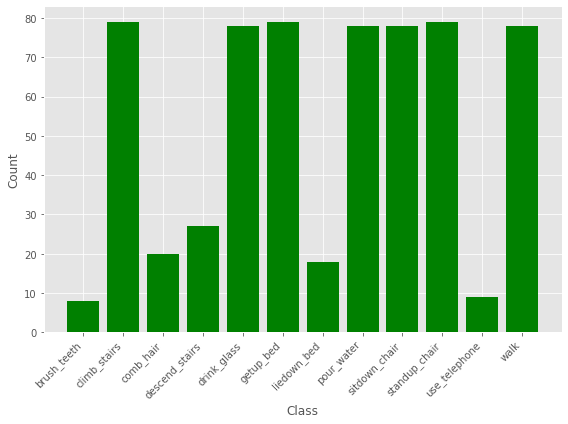

In [8]:
# ADL dataset class counts (training set)
show_class_counts(y_train, classes, xtick_rotation=45, title=None)

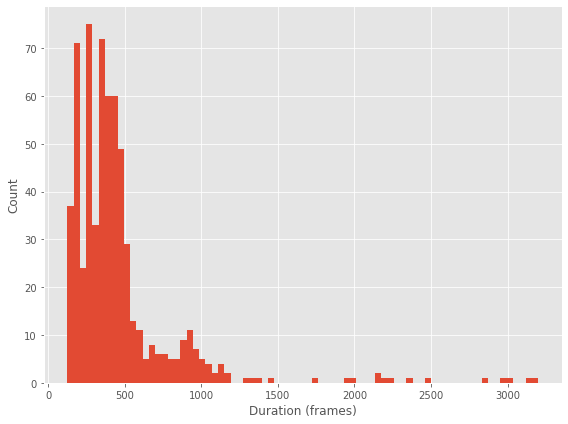

In [9]:
# Histogram of ADL dataset gesture durations (training set)
show_durations(X_train, bins=75, title=None)

## Signal visualization

In [10]:
def plot_signal(signal, figsize=(8, 6), title=None):
    """Function for visualizing an accelerometer signal"""
    title = 'Accelerometer signals' if title is None else title
    labels = ['X', 'Y', 'Z']
    colors = ['blue', 'red', 'green']
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=figsize)
    for i, ax in enumerate(axs.flat):
        ax.plot(signal[:, i], label=labels[i], color=colors[i])
        ax.legend(loc='upper right')
    fig.tight_layout()
    fig.subplots_adjust(top=0.92)
    fig.suptitle(title)
    plt.show()

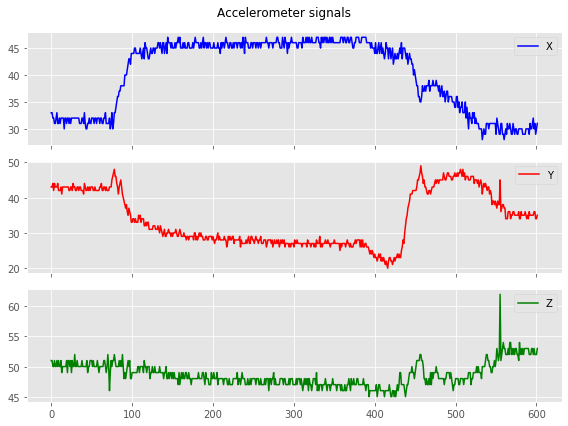

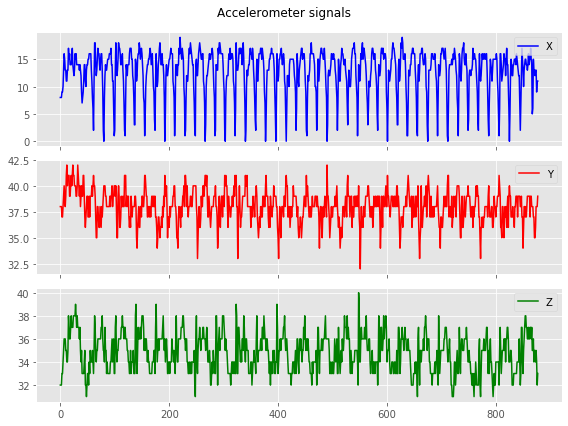

In [11]:
# Plot some sample accelerometer signals from the training set
for signal in X_train[:2]:
    plot_signal(signal)

## Preprocessing

In [12]:
from sequentia.preprocessing import filtrate, center

# Create a preprocessing pipeline
def pre(XX):
    XX = filtrate(XX, n=10, method='median')
    XX = smart_downsample(XX, m=50, method='decimate')
    XX = center(XX)
    return XX

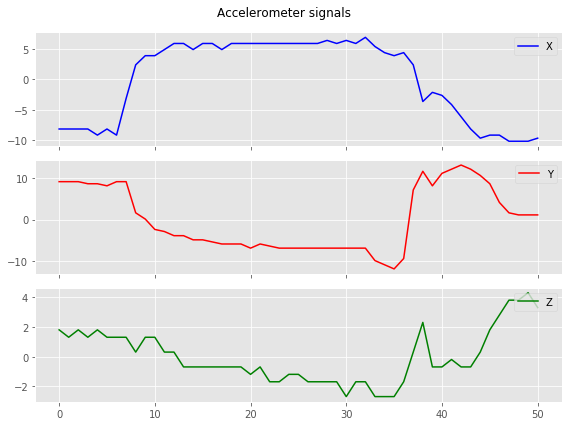

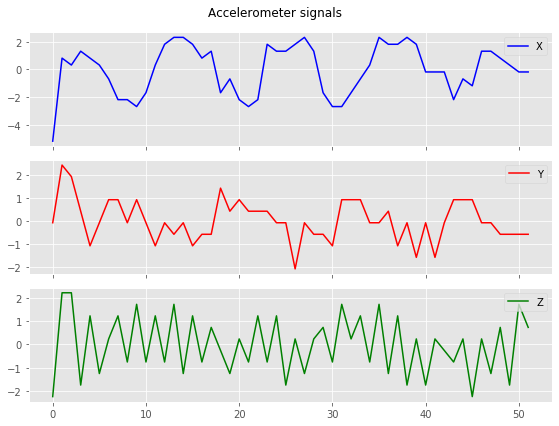

In [13]:
# Plot the same sample accelerometer signals, but preprocessed
for signal in pre(X_train[:2]):
    plot_signal(signal)

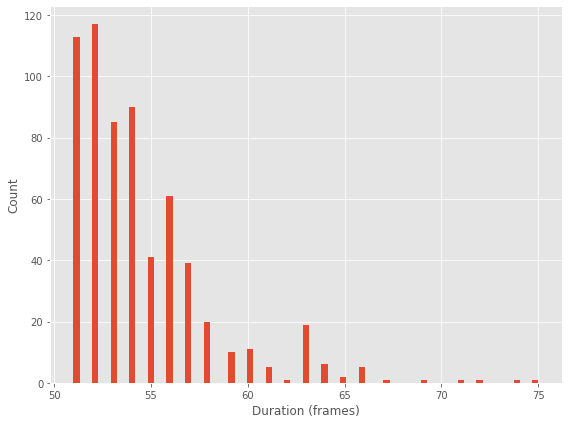

In [14]:
# Histogram of ADL dataset gesture durations (preprocessed) (training set)
Xp_train = pre(X_train)
show_durations(Xp_train, bins=75, title=None)

In [15]:
# Apply the preprocessing pipeline to the other dataset splits
Xp_val, Xp_test = pre(X_val), pre(X_test)

## DTWKNN classifier

### Fitting the model

In [16]:
%%time
# Fit a DTWKNN classifier on the training data
clfs['knn'] = seq.classifiers.DTWKNN(k=1, radius=1)
clfs['knn'].fit(Xp_train, y_train)

CPU times: user 4.13 ms, sys: 3.7 ms, total: 7.82 ms
Wall time: 5.93 ms


### Evaluating the model

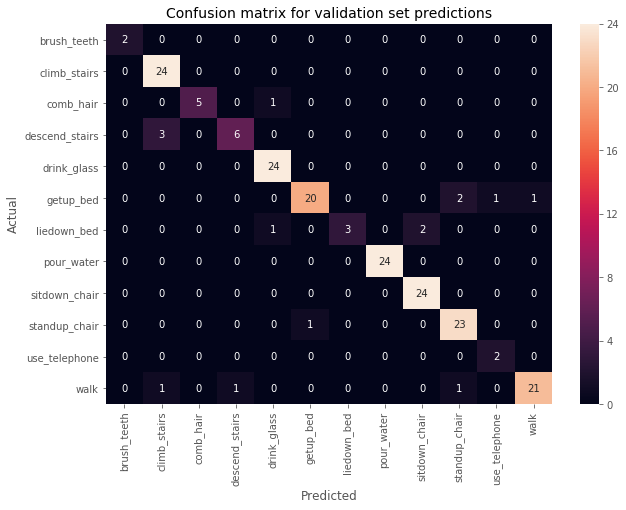

Accuracy: 92.23%
CPU times: user 899 ms, sys: 236 ms, total: 1.13 s
Wall time: 15min 24s


In [17]:
%%time
# Classify the validation examples and display accuracy and confusion matrix
results['knn']['validation'] = clfs['knn'].evaluate(Xp_val, y_val, labels=classes, n_jobs=-1)
show_results(*results['knn']['validation'], dataset='validation', labels=classes)

## Hidden Markov Model classifier

### Fitting the model

In [18]:
%%time

# Create HMMs to represent each class
#
# NumPy sometimes raises some errors as a result of instability during the Cholesky decomposition.
# According to issue #414 on Pomegranate's GitHub repository, this may be caused by:
# - Too many states in the HMMs
# - Too many dimensions in the input data, which leads to a large covariance matrix
# - Too few training examples
hmms = []
for c in tqdm(classes, desc='Training HMMs'):
    hmm = seq.classifiers.HMM(label=c, n_states=7, random_state=rng)
    hmm.set_random_initial()
    hmm.set_random_transitions()
    hmm.fit([Xp_train[i] for i, label in enumerate(y_train) if label == c])
    hmms.append(hmm)
    
# Fit a HMM classifier with the HMMs
clfs['hmm'] = seq.classifiers.HMMClassifier()
clfs['hmm'].fit(hmms)


CPU times: user 21.2 s, sys: 329 ms, total: 21.5 s
Wall time: 23.5 s


### Evaluating the model

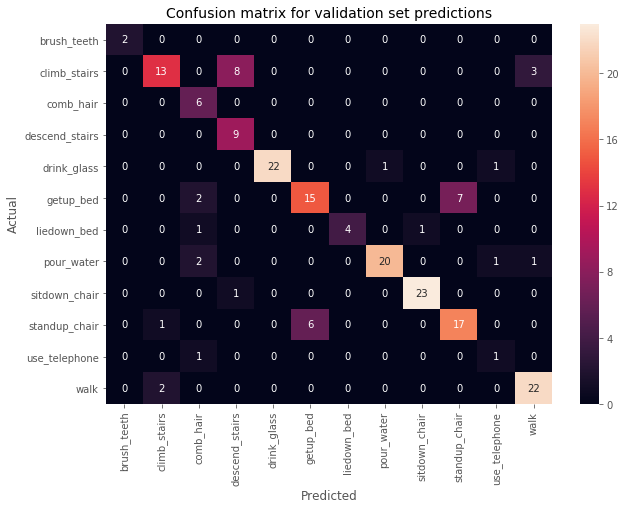

Accuracy: 79.79%
CPU times: user 1.24 s, sys: 72.3 ms, total: 1.31 s
Wall time: 1.41 s


In [19]:
%%time
# Classify the validation examples and display accuracy and confusion matrix
results['hmm']['validation'] = clfs['hmm'].evaluate(Xp_val, y_val, labels=classes)
show_results(*results['hmm']['validation'], dataset='validation', labels=classes)

## LSTM classifier

### Fitting the model

In [20]:
%%time
from tensorflow.keras.optimizers import Adam
clfs['lstm'] = LSTMClassifier(epochs=50, batch_size=256, optimizer=Adam(learning_rate=0.0015), classes=classes)
hist = clfs['lstm'].fit(Xp_train, y_train, validation_data=(Xp_val, y_val), return_history=True)

Train on 631 samples, validate on 193 samples
Epoch 1/50
631/631 [==============================] - 4s 6ms/sample - loss: 2.4721 - accuracy: 0.1680 - val_loss: 2.4251 - val_accuracy: 0.2539
Epoch 2/50
631/631 [==============================] - 1s 1ms/sample - loss: 2.3883 - accuracy: 0.2504 - val_loss: 2.2599 - val_accuracy: 0.2487
Epoch 3/50
631/631 [==============================] - 1s 2ms/sample - loss: 2.1896 - accuracy: 0.2456 - val_loss: 2.0524 - val_accuracy: 0.2487
Epoch 4/50
631/631 [==============================] - 1s 1ms/sample - loss: 2.0673 - accuracy: 0.2472 - val_loss: 2.0001 - val_accuracy: 0.2435
Epoch 5/50
631/631 [==============================] - 1s 2ms/sample - loss: 1.9551 - accuracy: 0.2456 - val_loss: 1.9354 - val_accuracy: 0.2280
Epoch 6/50
631/631 [==============================] - 1s 2ms/sample - loss: 1.8897 - accuracy: 0.2726 - val_loss: 1.8891 - val_accuracy: 0.2332
Epoch 7/50
631/631 [==============================] - 1s 1ms/sample - loss: 1.8223 - accur

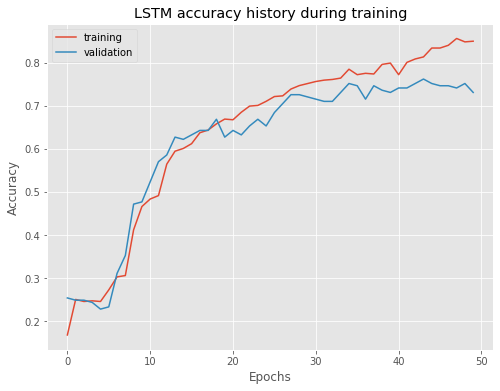

In [21]:
# Display accuracy history during training
show_accuracy_history(hist)

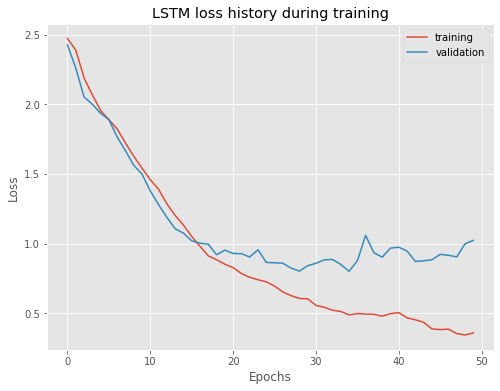

In [22]:
# Display loss history during training
show_loss_history(hist)

### Evaluating the model

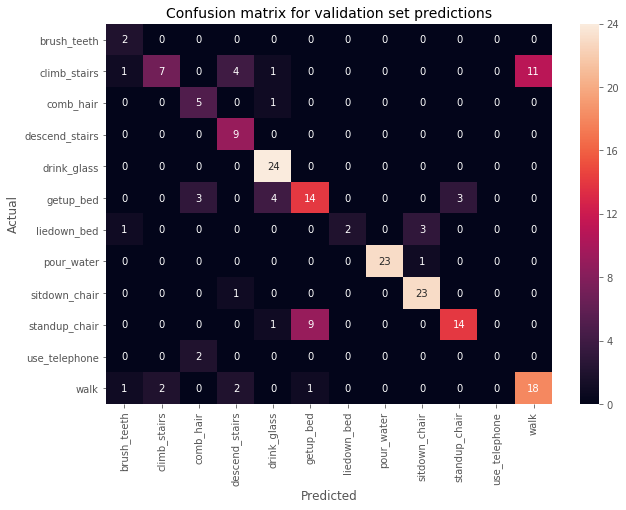

Accuracy: 73.06%
CPU times: user 1.18 s, sys: 100 ms, total: 1.28 s
Wall time: 1.3 s


In [23]:
%%time
results['lstm']['validation'] = clfs['lstm'].evaluate(Xp_val, y_val)
show_results(*results['lstm']['validation'], dataset='validation', labels=classes)